In [1]:
import pandas as pd
import numpy as np
import random
import itertools
from scipy.stats import loguniform
import math
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

#### Last time, the goal was to find out how many of these systems have transiting planets.
Create 20000 FGK dwarfs using the age distribution from Berger et al 2020a, with planets drawn from loguniform period distribution from 2 to 300 days, following the following cases:<br>

1) no difference between old and young stars, with 3 planets per star <br>
2) 10% of systems still intact (5 or 6 planets; < 2 Gyr old); 90% of systems disrupted (1 or 2 planets; > 2 Gyr) <br>

Why these two cases? Kepler data shows 7% (here we round to 10%) of systems are intact. We're using 2 Gyr instead of 1 Gyr like Berger et al in order to maintain the ~10%/90% proportion of sample sizes. ME FROM THE FUTURE: This is a wrong assumption. Skip to end of Case 2. <br>

#### Now, we repeat the experiment while varying the age cutoff for young vs old from 1 to 10 Gyrs in increments of 1 Gyr. For each bin, we calculate the posterior likelihood.

In [2]:
berger_kepler = pd.read_csv('berger_kepler_stellar17.csv')
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

In [3]:
pnum = pd.read_csv('pnum.csv')
print(len(pnum))
pnums = [int(p) for p in pnum.loc[pnum.pl_pnum > 0].pl_pnum]
print(pnums)
print(len(pnums))

20014
[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 5, 5, 5, 5, 5, 1, 1, 2, 2, 1, 1, 3, 3, 3, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 3, 3, 2, 2, 1]
161


[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


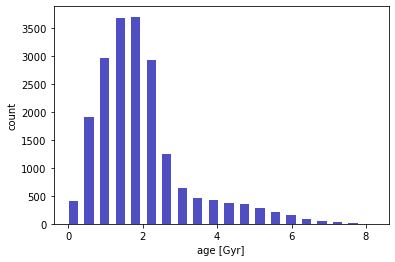

In [4]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

0.16134894568048957
0.13801577758850292
20000 [1.50241241 5.22188188 0.55791792 ... 1.22658659 1.19315315 1.7448048 ]


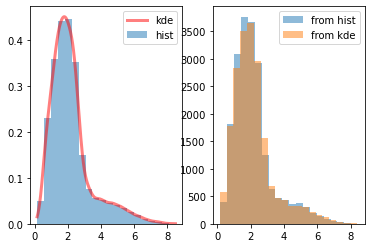

[1.50241241 5.22188188 0.55791792 ... 1.22658659 1.19315315 1.7448048 ]


In [5]:
# courtesy of https://stackoverflow.com/questions/17821458/random-number-from-histogram
from scipy.stats import gaussian_kde

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

#kdepdf = kde(x, x_d, bandwidth=0.1) # generate KDE model
#random_from_kde = generate_rand_from_pdf(kdepdf, x_d) # generate random data from KDE distribution

nbins = 20
def run_kde(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
    print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(random_from_kde, nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde, random_from_cdf
    
stars_age1_kde, stars_age1_cdf = run_kde(berger_kepler.iso_age, 20000)
print(stars_age1_kde)

60000 [111.3157654    2.1212214   28.94850219 ...  30.57518121  26.79624939
  27.48041965]
[25713  7615  4500  3279  2572  2121  1846  1530  1367  1235  1118  1026
   954   874   820   771   712   679   669   599]
[  2.00009447  16.89972042  31.79934637  46.69897231  61.59859826
  76.49822421  91.39785016 106.29747611 121.19710206 136.09672801
 150.99635396 165.89597991 180.79560586 195.69523181 210.59485776
 225.49448371 240.39410966 255.29373561 270.19336156 285.09298751
 299.99261346]


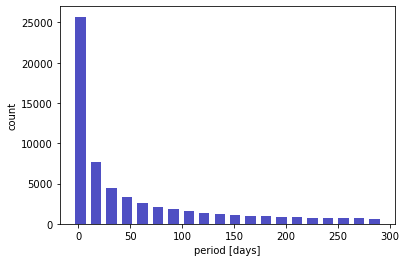

In [6]:
# host star follows age distribution of Berger et al 2020a
# 3 planets per star, with periods following loguniform distribution in [2, 300] days
from scipy.stats import loguniform

planets_per1 = loguniform.rvs(2, 300, size=60000)
print(len(planets_per1), planets_per1)

# histogram for 60000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per1, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

[3021 2910 3067 2981 2938 3014 3201 3019 2997 3000 3036 2926 2970 2997
 2915 3072 2932 2979 3005 3020]
[0.69319441 0.94372258 1.19425076 1.44477893 1.6953071  1.94583527
 2.19636344 2.44689162 2.69741979 2.94794796 3.19847613 3.4490043
 3.69953248 3.95006065 4.20058882 4.45111699 4.70164516 4.95217334
 5.20270151 5.45322968 5.70375785]


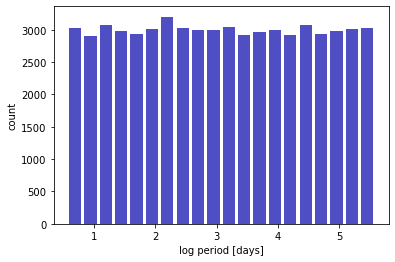

In [7]:
per_hist, per_bin_edges = np.histogram(np.log(planets_per1), bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 0.2, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("log period [days]")
plt.show()

### Transits

0.38690748364419597
0.13801577758850292
20000 [1.52377377 1.36669269 2.29754354 ... 1.58776977 1.53540941 3.50183183]


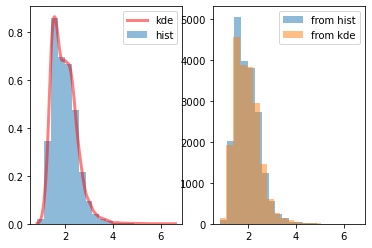

In [8]:
stars_radius_kde, stars_radius_cdf = run_kde(berger_kepler.iso_rad, 20000)

In [9]:
def transit_duration(P, r_star, r_planet, b, a, inc): # Winn 2011 Eqn 14
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    arg2 = (r_star / a) * (arg1 / np.sin(np.pi/2 - inc)) # was sin(i) but need to adjust for different index
    return (P / np.pi) * np.arcsin(arg2)

def transit_duration_paw(P, r_star, r_planet, b, a, inc): 
    # https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    arg2 = (r_star / a) * arg1 # the only difference is I don't divide by sin(i)
    return (P / np.pi) * np.arcsin(arg2)
    
def transit_duration_normalized_fab(P, r_star, r_planet, b): # Fabrycky 2012 unnamed eqn at the end of pg 8
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    return 2 * arg1 * r_star / (P**(-1./3))
    
def calculate_xi(tdur1, tdur2, P1, P2): # Fabrycky 2012 Eqn 1
    arg1 = tdur1/(P1**(1./3))
    arg2 = tdur2/(P2**(1./3))
    return arg1 / arg2

def day_to_year(per):
    return per/365.24 

def solar_radius_to_au(radius):
    return 0.00465047*radius

def earth_radius_to_au(radius):
    return 4.26352e-5*radius

def sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star):
    """
    In a loop of stellar radii: draw number of planets and their periods, draw midplane for the system, 
    draw inclination from the midplane for each planet, convert period to a, calculate impact parameter b, 
    calculate transit duration, calculate normalized transit duration xi (aka mutual inclination proxy),
    classify each planet as transiting or not
    
    Parameters
    ----------
    r_star: radius of the star
    num_planets: number of planets sampled based on stellar age check
    mu: planetary disk midplane in radians
    sigma: sigma used in drawing planet inclinations from around the midplane
    mu_degrees: nobody's perfect
    sigma_degrees: nobody's perfect
    r_planet: radius of the planet
    age_star: age of the star
    
    Returns
    -------
    None: populates a bunch of different lists set up before the loop in which function is called,
    including those for inclination, period, semi-major axis, impact parameter, and transit duration
    
    """
    
    # draw planet periods from loguniform distribution according to num_planets
    planet_per_case2 = loguniform.rvs(2, 300, size=num_planets) 
    planets_per_case2.append(planet_per_case2) 

    # inclinations for impact parameter formula
    inclination = np.random.normal(mu, sigma, num_planets) # need this for later
    inclinations.append(inclination) 
    inclinations_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) 

    # semi-major axes
    planet_a_case2 = day_to_year(planet_per_case2)**(2./3) # calculate semi-major axes based on Kepler's Third Law
    planets_a_case2.append(planet_a_case2) 

    # calculate impact parameters
    b = (planet_a_case2 * np.sin(inclination))/r_star
    impact_parameters.append(b)

    # calculate transit durations using Winn 2011 formula
    tdur = transit_duration(day_to_year(planet_per_case2), solar_radius_to_au(r_star), 
                            solar_radius_to_au(r_planet), b, planet_a_case2, inclination)
    
    """
    ### calculate xi for the system
    # periods and tdurs already match, so divide them to get normalized tdurs
    tdur_normalized = tdur/(day_to_year(planet_per_case2)**(1./3))

    # make sure I keep info on which tdur_normalized corresponds with which planet
    temp = pd.DataFrame({'period': planet_per_case2, 'tdur_normalized': tdur_normalized})
    temp = temp.dropna()

    # guarantee that xi will always have normalized transit durations of inner planet in numerator 
    temp = temp.sort_values(by='period') 
    #print(temp)
    tdur_normalized_combos = list(itertools.combinations(temp.tdur_normalized,2))
    #print("combos: ", tdur_normalized_combos)

    for combo in tdur_normalized_combos:
        xi.append(combo[0]/combo[1])
        if age_star <= 1.:
            xi_young.append(combo[0]/combo[1])
        elif age_star > 1:
            xi_old.append(combo[0]/combo[1])
    """

    # note individual planets' transit status
    transit_status.append([1 if np.abs(param) <= 1. else 0 for param in b])

    # transit check based on impact parameters
    transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))

In [69]:
"""
# we use stars_age1_kde and planets_per1
# units are AU and year
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 2

path = '/Users/chris/Desktop/sculpting/'
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2
for j in range(10)[5:10]:
    star_index = []
    midplanes = []
    midplanes_degrees = []
    inclinations = []
    inclinations_degrees = []
    planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
    planets_a_case2 = []
    star_radius = []
    impact_parameters = []
    transit_status = []
    transit_multiplicities = []
    xi = []
    xi_old = []
    xi_young = []
    threshold = float(j+1)
    print(threshold)
    for i in range(len(stars_radius_kde)):
        # star
        star_index.append(i)
        #r_star = stars_radius_kde[i] # nope
        r_star = solar_radius_to_au(1.) # set to 1 solar radius
        age_star = stars_age1_kde[i]
        mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star 
        mu_degrees = np.random.uniform(-90,90,1) # more interpretable
        midplanes.append(mu)
        midplanes_degrees.append(mu_degrees)

        # planet
        r_planet = earth_radius_to_au(2.) # use two Earth radii; will make negligible difference
        if age_star <= threshold:
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 

            # simulate transit-related characteristics for 5 or 6 planets
            sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)

        elif age_star > threshold:
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 

            # simulate transit-related characteristics for 1 or 2 planets
            sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)

    midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

    transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case2, 
                     'semi_major_axes': planets_a_case2, 'midplane': midplanes, 
                     'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                     'planet_inclinations_degrees': inclinations_degrees, 'star_radius': stars_radius_kde, 
                     'impact_parameters': impact_parameters, 'transit_status': transit_status, 
                     'transit_multiplicity': transit_multiplicities, 'star_index': star_index}

    transits_case2 = pd.DataFrame(transits_dict)
    #print(transits_case2.head())
    print(len(transits_case2))
    transits_case2.to_csv(path+'transit_data_' + str(int(j)+1) + '.csv', index=False)
"""   

6.0
20000
7.0
20000
8.0
20000
9.0
20000
10.0
20000


In [11]:
from glob import glob
import os
path = '/Users/chris/Desktop/sculpting/'
# can't order by filename b/c then 10 < 2; instead, order by time of file creation
file_names = sorted(glob(path+'models/transit_data_*.csv'), key=os.path.getmtime)
print(file_names)

# create dfs as part of a dict
dfs = {i+1: pd.read_csv(path+'models/transit_data_'+str(i+1)+'.csv') for i in range(len(file_names))}
print(dfs[1].head())

['/Users/chris/Desktop/sculpting/models/transit_data_1.csv', '/Users/chris/Desktop/sculpting/models/transit_data_2.csv', '/Users/chris/Desktop/sculpting/models/transit_data_3.csv', '/Users/chris/Desktop/sculpting/models/transit_data_4.csv', '/Users/chris/Desktop/sculpting/models/transit_data_5.csv', '/Users/chris/Desktop/sculpting/models/transit_data_6.csv', '/Users/chris/Desktop/sculpting/models/transit_data_7.csv', '/Users/chris/Desktop/sculpting/models/transit_data_8.csv', '/Users/chris/Desktop/sculpting/models/transit_data_9.csv', '/Users/chris/Desktop/sculpting/models/transit_data_10.csv']
   star_ages               planet_periods          semi_major_axes  midplane  \
0   3.316176      [8.64529076 3.85626988]  [0.08243928 0.04812744]  1.162765   
1   1.619429  [251.07746444  16.56609854]  [0.77890818 0.12718267] -1.100988   
2   2.254665      [4.79505557 5.71131505]  [0.0556515  0.06253241]  0.513240   
3   2.279740                [27.96391226]              [0.1803072]  1.511828  

In [12]:
for i in range(len(file_names)):
    print(len(dfs[i+1].loc[dfs[i+1].transit_multiplicity > 0]))


791
1023
1295
1353
1353
1395
1393
1406
1381
1351


In [13]:
transits_case2 = dfs[1]
transits_case2.loc[transits_case2.star_ages < 1.].head()

,star_ages,planet_periods,semi_major_axes,midplane,midplane_degrees,planet_inclinations,planet_inclinations_degrees,star_radius,impact_parameters,transit_status,transit_multiplicity,star_index
10,0.666577,[ 23.93631154 181.5553408 6.7338864 2.04...,[0.16254961 0.62750973 0.06978975 0.03148826 0...,0.230943,[46.39894863],[0.2379208 0.25828986 0.28671309 0.17223877 0...,[48.81168399 43.71163982 47.87714417 46.705262...,1.896114,[ 8.23789834 34.46603313 4.24400378 1.160468...,"[0, 0, 0, 0, 0, 0]",0,10
16,0.348959,[52.97206715 7.55747501 46.54025017 39.630216...,[0.27604447 0.07537007 0.25322131 0.22749162 0...,1.523946,[22.86911402],[1.54891391 1.54225054 1.45126496 1.56215 1...,[25.93159797 22.3299936 22.0286873 24.232224...,2.588434,[59.34419235 16.20037649 54.06216637 48.916156...,"[0, 0, 0, 0, 0, 0]",0,16
20,0.833744,[ 8.99319938 13.32366598 7.91164268 27.322060...,[0.08463641 0.10999263 0.07770678 0.17753749 0...,0.439137,[-8.68629547],[0.38067789 0.42936338 0.48853947 0.46399735 0...,[-12.38083175 -6.1394396 -7.16462661 -10.71...,1.360875,[ 6.76203762 9.8461143 7.84235622 17.084877...,"[0, 0, 0, 0, 0]",0,20
24,0.733443,[ 51.98333359 2.59832002 140.81440294 16.29...,[0.27259875 0.03698931 0.52971934 0.12576852 0...,-1.201682,[-5.39004558],[-1.19580833 -1.13383593 -1.18498956 -1.186710...,[-6.33100349 -5.530245 -2.5993743 -3.688169...,1.686673,[ -54.54425333 -7.20655602 -105.53393419 -2...,"[0, 0, 0, 0, 0, 0]",0,24
61,0.449259,[ 3.30036579 28.91259956 2.02924668 2.346066...,[0.04338329 0.18436248 0.03136926 0.03455477 0...,-0.977624,[13.33878488],[-0.98140007 -0.98279448 -0.8925048 -1.014947...,[15.23416258 9.22542411 14.45856676 16.734055...,1.727397,[ -7.75480912 -32.98568368 -5.25227516 -6.31...,"[0, 0, 0, 0, 0, 0]",0,61


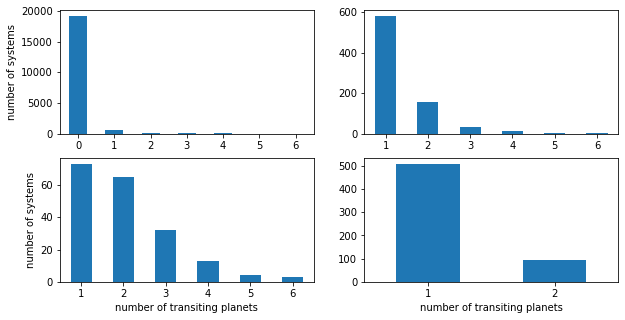

In [14]:
# plot transit multiplicity 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 2, 1)
transits_case2.transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')

# systems w/transiters only
ax = fig.add_subplot(2, 2, 2)
transits_case2.loc[transits_case2.transit_multiplicity > 0].transit_multiplicity.value_counts().plot(kind='bar', rot=0)

# young systems w/transiters
ax = fig.add_subplot(2, 2, 3)
transits_case2.loc[(transits_case2.star_ages < 1.) & (transits_case2.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')
plt.xlabel('number of transiting planets')

# old systems w/transiters
ax = fig.add_subplot(2, 2, 4)
transits_case2.loc[(transits_case2.star_ages > 1.) & (transits_case2.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.xlabel('number of transiting planets')

plt.show()

# young systems with one tranister shouldn't be the majority but should be overrepresented than expected
# this isn't the case...why?

In [15]:
print(len(transits_case2.loc[(transits_case2.star_ages > 1.)])) # total old'uns
print(len(transits_case2.loc[(transits_case2.star_ages < 1.)])) # total young'uns
print(len(transits_case2.loc[(transits_case2.star_ages > 1.) & (transits_case2.transit_multiplicity > 0)])) # old'uns w/transiters
print(len(transits_case2.loc[(transits_case2.star_ages < 1.) & (transits_case2.transit_multiplicity > 0)])) # young'uns w/transiters

# young systems w/transiters
print(len(transits_case2.loc[(transits_case2.star_ages < 1.) & (transits_case2.transit_multiplicity > 0)])/len(transits_case2.loc[(transits_case2.star_ages < 1.)]))
# old systems w/transiters
print(len(transits_case2.loc[(transits_case2.star_ages > 1.) & (transits_case2.transit_multiplicity > 0)])/len(transits_case2.loc[(transits_case2.star_ages > 1.)]))

# this is weird - we'd expect young systems, which have more close-in planets, to have more transiters on average
# maybe these differences disappear before the 1 Gyr threshold of young vs old? But then we'd expect them to be the same...
# or maybe the loguniform period draws aren't biased enough to get close-in-enough periods for transit effects to kick in. Same problem as above though...

print((190+601)/(2521+17479))
print(np.mean(transits_case2.transit_multiplicity))
print(np.mean(transits_case2.loc[transits_case2.transit_multiplicity > 0].transit_multiplicity))


17479
2521
601
190
0.0753669178897263
0.034384118084558615
0.03955
0.05415
1.3691529709228825


### Posteriors

Poisson probability: P(k|lambda) = lambda^k * e^-lambda / k!, where k is count in the data and lambda is the expected count from each tuned model of simulations with varied age cutoffs <br>
Poisson likelihood: L = PI from i to N (lambda_i^k_i * e^-lambda_i / k_i!)

For each system, how many do I expect to transit? ie. vary age threshold to get 10 sets of systems; for each set, expected value = variance = lambda (by Poisson distribution) = number of stars at each transit multiplicity bin. k is the data version of this.

<AxesSubplot:>

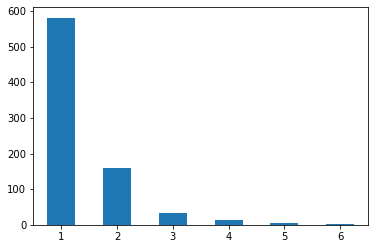

In [16]:
transits_case2.loc[transits_case2.transit_multiplicity > 0].transit_multiplicity.value_counts().plot(kind='bar', rot=0)


In [17]:
len(pnum.loc[pnum.pl_pnum > 0])

161

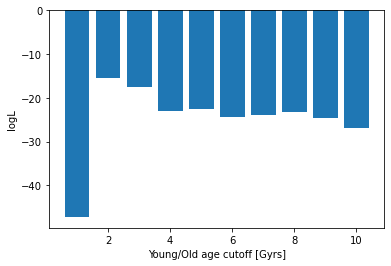

In [18]:
from math import lgamma

def calculate_logL(k, lam):
    term1 = np.sum(k * np.log(lam))
    term2 = -np.sum(lam)
    term3 = -np.sum([lgamma(kth + 1) for kth in k])
    return term1 + term2 + term3
    
k = pnum.pl_pnum.value_counts()
#print(k)
logLs = []

"""
for i in range(len(file_names)): 
    lam = dfs[i+1].transit_multiplicity.value_counts()
    logL = calculate_logL(k, lam)
    logLs.append(logL)
    print(logL)
"""
# lambdas artificially generate way more transiting planets than data
# so a fairer comparison is to scale lambdas according to the number of transiting planets in Berger data: 161
for i in range(len(file_names)): 
    #print(len(dfs[i+1].loc[dfs[i+1].transit_multiplicity > 0]))
    #print(dfs[i+1].loc[dfs[i+1].transit_multiplicity > 0].transit_multiplicity.value_counts())
    lam = dfs[i+1].loc[dfs[i+1].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[i+1].loc[dfs[i+1].transit_multiplicity > 0]))
    #print(lam)
    logL = calculate_logL(k, lam)
    logLs.append(logL)
    #print(logL)

# plot log likelihood per model
plt.bar(range(11)[1:], logLs)
plt.xlabel('Young/Old age cutoff [Gyrs]')
plt.ylabel('logL')
plt.show()


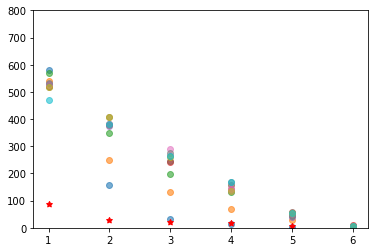

In [19]:
# plot each model's pre-normalized transit multiplicity distribution, and plot the data
for i in range(11)[1:]:
    #print(dfs[i].transit_multiplicity.value_counts())
    plt.scatter(np.arange(7)[1:], dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts(),
               alpha=0.6)

plt.scatter(np.arange(6)[1:], k, marker=(5, 1), color='r')
plt.ylim([0, 800])
plt.show()

Looks like greatest likelihood occurs at 2 Gyr cutoff. What's interesting is I didn't expect the 1 Gyr cutoff model to be the worst by far. Let's zoom in and do 0.1 Gyr increments from 0 to 2 Gyr inclusive. Edit: log likelihood is looking close so I'm going to add another 1 Gyr.

### 2nd Round of Models: 0 - 3 Gyr at 0.1 Gyr intervals

In [ ]:
# we use stars_age1_kde and planets_per1
# units are AU and year
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 2

"""
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2
#for threshold in np.linspace(0., 2., 21):
for threshold in np.linspace(2.1, 3.0, 10):
    star_index = []
    midplanes = []
    midplanes_degrees = []
    inclinations = []
    inclinations_degrees = []
    planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
    planets_a_case2 = []
    star_radius = []
    impact_parameters = []
    transit_status = []
    transit_multiplicities = []
    xi = []
    xi_old = []
    xi_young = []
    for i in range(len(stars_radius_kde)):
        # star
        star_index.append(i)
        #r_star = stars_radius_kde[i] # nope
        r_star = solar_radius_to_au(1.) # set to 1 solar radius
        age_star = stars_age1_kde[i]
        mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star 
        mu_degrees = np.random.uniform(-90,90,1) # more interpretable
        midplanes.append(mu)
        midplanes_degrees.append(mu_degrees)

        # planet
        r_planet = earth_radius_to_au(2.) # use two Earth radii; will make negligible difference
        if age_star <= threshold:
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 

            # simulate transit-related characteristics for 5 or 6 planets
            sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)

        elif age_star > threshold:
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 

            # simulate transit-related characteristics for 1 or 2 planets
            sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)

    midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

    transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case2, 
                     'semi_major_axes': planets_a_case2, 'midplane': midplanes, 
                     'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                     'planet_inclinations_degrees': inclinations_degrees, 'star_radius': stars_radius_kde, 
                     'impact_parameters': impact_parameters, 'transit_status': transit_status, 
                     'transit_multiplicity': transit_multiplicities, 'star_index': star_index}

    transits_case2 = pd.DataFrame(transits_dict)
    transits_case2.to_csv(path+'zoomed_in_models/transit_data_' + str(int(threshold*10)) + '.csv', index=False)
"""

In [20]:
# get file names and order by time of file creation
file_names = sorted(glob(path+'zoomed_in_models/transit_data_*.csv'), key=os.path.getmtime)

# create dfs as part of a dict
dfs = {i: pd.read_csv(path+'zoomed_in_models/transit_data_'+str(i)+'.csv') for i in range(len(file_names))}
print(dfs[0].head())

   star_ages             planet_periods          semi_major_axes  midplane  \
0   3.316176               [6.13616933]              [0.0655963]  1.465050   
1   1.619429              [42.50354202]              [0.2383588] -0.614413   
2   2.254665               [2.86737323]             [0.03950062] -0.035847   
3   2.279740  [22.84697355 38.70057955]  [0.15757969 0.22391993] -0.671230   
4   1.886897               [2.54534916]             [0.03648486] -0.944903   

  midplane_degrees        planet_inclinations planet_inclinations_degrees  \
0     [74.1942903]               [1.51815482]               [75.68557601]   
1   [-58.11480658]              [-0.52891657]              [-56.43117722]   
2    [72.95874552]              [-0.00172092]                [70.8931305]   
3    [55.18156882]  [-0.65756448 -0.65340019]   [54.06124959 53.44475258]   
4    [85.72311062]              [-0.91852919]               [82.37342782]   

   star_radius            impact_parameters transit_status  \
0     

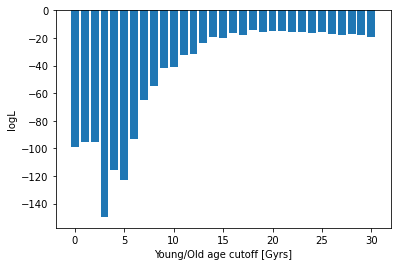

In [21]:
logLs = []
for i in range(len(file_names)): 
    lam = dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[i].loc[dfs[i].transit_multiplicity > 0]))
    #print(lam)
    logL = calculate_logL(k, lam)
    logLs.append(logL)
    #print(logL)

# plot log likelihood per model
plt.bar(range(31), logLs)
plt.xlabel('Young/Old age cutoff [Gyrs]')
plt.ylabel('logL')
plt.show()

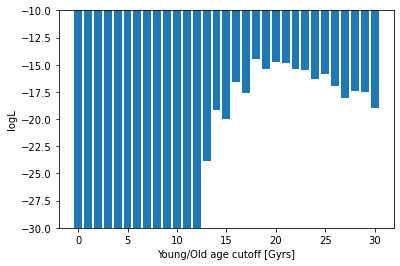

In [22]:
logLs = []
for i in range(len(file_names)): 
    lam = dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[i].loc[dfs[i].transit_multiplicity > 0]))
    #print(lam)
    logL = calculate_logL(k, lam)
    logLs.append(logL)
    #print(logL)

# plot log likelihood per model
plt.bar(range(31), logLs)
plt.xlabel('Young/Old age cutoff [Gyrs]')
plt.ylabel('logL')
plt.ylim([-30, -10])
plt.show()

In [23]:
print(np.argmax(logLs))

18


In [24]:
logLs[30] - logLs[18]

-4.481185474355357

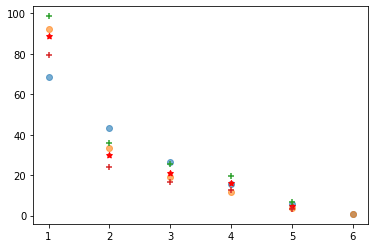

In [25]:
# plot each model's pre-normalized transit multiplicity distribution, and plot the data
tmult1 = []
tmult2 = []
tmult3 = []
tmodel3 = []
tmult4 = []
tmodel4 = []
tmult5 = []
tmodel5 = []
tmult6 = []
tmodel6 = []
#for i in range(31):
    #print(dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts())
i = 30
current = dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[i].loc[dfs[i].transit_multiplicity > 0]))
"""
    tmult1.append(current[1])
    tmult2.append(current[2])
    try:
        tmult3.append(current[3])
        tmodel3.append(i)
    except:
        pass
    try:
        tmult4.append(current[4])
        tmodel4.append(i)
    except:
        pass
    try:
        tmult5.append(current[5])
        tmodel5.append(i)
    except:
        pass
    try:
        tmult6.append(current[6])
        tmodel6.append(i)
    except:
        pass
    plt.scatter(current.index, current, alpha=0.6)"""
plt.scatter(current.index, current, alpha=0.6)
i = 18
current = dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[i].loc[dfs[i].transit_multiplicity > 0]))
plt.scatter(current.index, current, alpha=0.6)
plt.scatter(np.arange(6)[1:], k, marker=(5, 1), color='r')
plt.scatter(np.arange(7)[1:], k+np.sqrt(current), marker='+')
plt.scatter(np.arange(7)[1:], k-np.sqrt(current), marker='+')

# double check first model
#plt.scatter(dfs[0].loc[dfs[0].transit_multiplicity > 0].transit_multiplicity.value_counts().index, 
#            dfs[0].loc[dfs[0].transit_multiplicity > 0].transit_multiplicity.value_counts(), 
#            color='k', marker='+')
plt.show()

In [26]:
k+np.sqrt(current)

1.0    98.599600
2.0    35.788777
3.0    25.363454
4.0    19.402375
5.0     6.951396
6.0          NaN
dtype: float64

In [27]:
current

1    92.152318
2    33.509934
3    19.039735
4    11.576159
5     3.807947
6     0.913907
Name: transit_multiplicity, dtype: float64

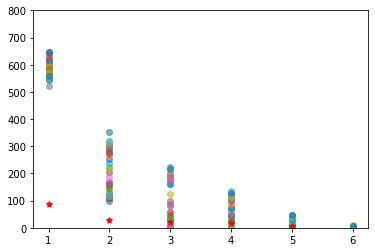

In [28]:
# plot each model's pre-normalized transit multiplicity distribution, and plot the data
tmult1 = []
tmult2 = []
tmult3 = []
tmodel3 = []
tmult4 = []
tmodel4 = []
tmult5 = []
tmodel5 = []
tmult6 = []
tmodel6 = []
for i in range(31):
    #print(dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts())
    current = dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts()
    tmult1.append(current[1])
    tmult2.append(current[2])
    try:
        tmult3.append(current[3])
        tmodel3.append(i)
    except:
        pass
    try:
        tmult4.append(current[4])
        tmodel4.append(i)
    except:
        pass
    try:
        tmult5.append(current[5])
        tmodel5.append(i)
    except:
        pass
    try:
        tmult6.append(current[6])
        tmodel6.append(i)
    except:
        pass
    plt.scatter(current.index, current, alpha=0.6)

plt.scatter(np.arange(6)[1:], k, marker=(5, 1), color='r')

# double check first model
#plt.scatter(dfs[0].loc[dfs[0].transit_multiplicity > 0].transit_multiplicity.value_counts().index, 
#            dfs[0].loc[dfs[0].transit_multiplicity > 0].transit_multiplicity.value_counts(), 
#            color='k', marker='+')
plt.ylim([0, 800])
plt.show()

In [29]:
np.argmax(logLs), np.argmin(logLs)

(18, 3)

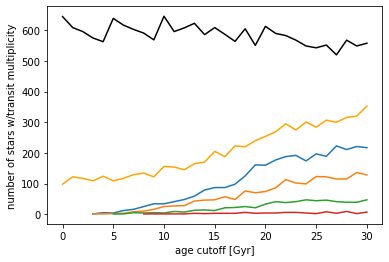

In [30]:
plt.plot(range(31), tmult1, c='k')
plt.plot(range(31), tmult2, c='orange')
plt.plot(tmodel3, tmult3)
plt.plot(tmodel4, tmult4)
plt.plot(tmodel5, tmult5)
plt.plot(tmodel6, tmult6)
plt.xlabel('age cutoff [Gyr]')
plt.ylabel('number of stars w/transit multiplicity')
plt.show()

So I guess 1.8 Gyrs is the threshold now? 

### Continuous threshold

Instead of a single age cutoff determining whether a system has 5/6 vs 1/2 planets, let's dial the likelihood of remaining intact (ie. of being 5/6 planets) down with age. First, let's try with a line passing through 0.5 likelihood at 1.8 Gyr. 

In [90]:
def sample_threshold_model_test(age): # new
    b = np.random.uniform(0,1,1) 
    #m = np.random.uniform(-0.25,0,1) # this is crucial: at -0.25 slope with optimal b, >=4 Gyr systems 100% disrupted
    m = np.random.uniform(-0.125,0,1) # this is crucial: at -0.125 slope with optimal b, >=8 Gyr systems 100% disrupted
    y = m * age + b
    if y[0] < 0: # don't allow negative probabilities
        y[0] = 0
    return b[0], m[0], y[0]

def sample_threshold_model(): # new
    b = np.random.uniform(0,1,1) 
    #m = np.random.uniform(-0.125,0,1) # this is crucial: at -0.125 slope with optimal b, >=8 Gyr systems 100% disrupted
    m = np.random.uniform(-1,0,1) # >=1 Gyr systems 100% disrupted
    return b[0], m[0]

def will_u_be_intact(age): # old
    # m = (1-0.5)/(0-1.8) # doesn't work if I want linear bc anything greater than 3.5 Gyr has negative probability
    m = (1-0)/(0-np.max(stars_age1_kde)) # m = 8.423133133133133
    print(m)
    y = m * age + 1
    
    return y

print(will_u_be_intact(3))
print(sample_threshold_model_test(3))


-0.11955109103833533
0.641346726884994
(0.9646340288036607, -0.011540676287888366, 0.9300119999399956)


In [58]:
for i in range(10):
    p = sample_threshold_model_test(1.8)[2]
    print(p)
    print(np.random.choice(['intact', 'disrupted'], p=[p, 1-p]))

0.18104097000941977
disrupted
0.7477676848110822
intact
0.0
disrupted
0.22870829408910215
disrupted
0.42438414598728913
intact
0.16782827561573893
disrupted
0.8335024179870946
intact
0.7752528663687428
intact
0.4454251151296695
intact
0.029362984747910853
disrupted


In [91]:
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2
for sample in range(30): # did one run of 20 at shallow slopes
    b, m = sample_threshold_model() # get probability distribution of intactness with age
    star_index = []
    midplanes = []
    midplanes_degrees = []
    inclinations = []
    inclinations_degrees = []
    planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
    planets_a_case2 = []
    star_radius = []
    impact_parameters = []
    transit_status = []
    transit_multiplicities = []
    xi = []
    xi_old = []
    xi_young = []
    for i in range(len(stars_radius_kde)):
        # star
        star_index.append(i)
        #r_star = stars_radius_kde[i] # nope
        r_star = solar_radius_to_au(1.) # set to 1 solar radius
        age_star = stars_age1_kde[i]
        mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star 
        mu_degrees = np.random.uniform(-90,90,1) # more interpretable
        midplanes.append(mu)
        midplanes_degrees.append(mu_degrees)

        # planet
        r_planet = earth_radius_to_au(2.) # use two Earth radii; will make negligible difference
        prob = m * age_star + b # calculate probability given age from sampled distribution
        if prob < 0: # don't allow negative probabilities
            prob = 0
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 

            # simulate transit-related characteristics for 5 or 6 planets
            sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 

            # simulate transit-related characteristics for 1 or 2 planets
            sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)

    midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

    transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case2, 
                     'semi_major_axes': planets_a_case2, 'midplane': midplanes, 
                     'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                     'planet_inclinations_degrees': inclinations_degrees, 'star_radius': stars_radius_kde, 
                     'impact_parameters': impact_parameters, 'transit_status': transit_status, 
                     'transit_multiplicity': transit_multiplicities, 'star_index': star_index,
                    'y_intercept': b, 'slope': m}

    transits_case2 = pd.DataFrame(transits_dict)
    transits_case2.to_csv(path+'continuous_models/cont/transit_data_cont_' + str(sample) + '.csv', index=False)

In [78]:
"""
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2
for sample in range(1):
    b, m = 0.1, 0. # get probability distribution of control model
    star_index = []
    midplanes = []
    midplanes_degrees = []
    inclinations = []
    inclinations_degrees = []
    planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
    planets_a_case2 = []
    star_radius = []
    impact_parameters = []
    transit_status = []
    transit_multiplicities = []
    xi = []
    xi_old = []
    xi_young = []
    for i in range(len(stars_radius_kde)):
        # star
        star_index.append(i)
        #r_star = stars_radius_kde[i] # nope
        r_star = solar_radius_to_au(1.) # set to 1 solar radius
        age_star = stars_age1_kde[i]
        mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star 
        mu_degrees = np.random.uniform(-90,90,1) # more interpretable
        midplanes.append(mu)
        midplanes_degrees.append(mu_degrees)

        # planet
        r_planet = earth_radius_to_au(2.) # use two Earth radii; will make negligible difference
        prob = m * age_star + b # calculate probability given age from sampled distribution
        if prob < 0: # don't allow negative probabilities
            prob = 0
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 

            # simulate transit-related characteristics for 5 or 6 planets
            sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 

            # simulate transit-related characteristics for 1 or 2 planets
            sim_transits(r_star, num_planets, mu, sigma, mu_degrees, sigma_degrees, r_planet, age_star)

    midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

    transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case2, 
                     'semi_major_axes': planets_a_case2, 'midplane': midplanes, 
                     'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                     'planet_inclinations_degrees': inclinations_degrees, 'star_radius': stars_radius_kde, 
                     'impact_parameters': impact_parameters, 'transit_status': transit_status, 
                     'transit_multiplicity': transit_multiplicities, 'star_index': star_index,
                    'y_intercept': b, 'slope': m}

    transits_case2 = pd.DataFrame(transits_dict)
    transits_case2.to_csv(path+'continuous_models/control.csv', index=False)
"""

In [173]:
# get file names and order by time of file creation
# previously did it with /cont/transit_data_cont_*.csv
file_names = sorted(glob(path+'continuous_models/transit_data_*.csv'), key=os.path.getmtime)

# create dfs as part of a dict
dfs = {i: pd.read_csv(path+'continuous_models/transit_data_'+str(i)+'.csv', 
                      converters={'transit_status': eval}) for i in range(len(file_names))}
df_control = pd.read_csv(path+'continuous_models/control.csv',
                        converters={'transit_status': eval})
#print(dfs[0].head())

In [170]:
lam_control

1    122.283837
2     27.080158
3      6.135348
4      3.596583
5      1.269382
6      0.634691
Name: transit_multiplicity, dtype: float64

In [168]:
dfs[6].loc[dfs[6].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[6].loc[dfs[6].transit_multiplicity > 0]))


1    108.411205
2     28.762156
3     13.615222
4      6.807611
5      3.063425
6      0.340381
Name: transit_multiplicity, dtype: float64

In [169]:
k

1.0    89
2.0    30
3.0    21
4.0    16
5.0     5
Name: pl_pnum, dtype: int64

-127.18334481655978
-23.551256784951192
-49.46979410051017
-96.28080396952953
-86.73198186332309
-94.98356080560905
-21.209557723832518
-60.22343795263919
-28.549469930205532
-152.96467634729584
-95.95387267409296
-14.840817848740357
-81.85128375605927
-131.63559370928897
-97.31285183133048
-88.84060144748639
-77.8811013251767
-96.49506948910948
-125.79310331518195
-112.7805965344429
-99.01617119235402
-61.80919116796724
-28.01591359728957
-85.90050230350062
-98.62475928514004
-89.98357040696783
-95.85418568969521
-13.522619890004535
-124.61875419407227
-19.503592109261263
-43.654019389095765
[0.2210427617026489, 0.9063334832852228, 0.33654612695448904, 0.18043582747055664, 0.7878492659573725, 0.19843119564506814, 0.5094279472541713, 0.6165569641231515, 0.3417956209557663, 0.3120480504904549, 0.011016411951903504, 0.8289607468049651, 0.3742136072304497, 0.5999180056681286, 0.029966440595022407, 0.9099813274353732, 0.1911661283240561, 0.03881312884843269, 0.288993072339478, 0.9141035494

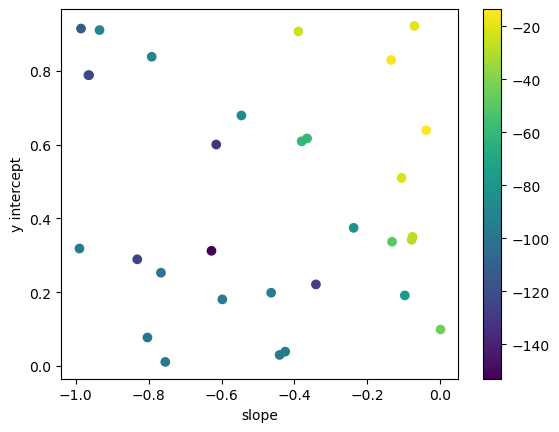

In [167]:
#plt.style.use('default')
logLs = []
ms = []
bs = []
#for i in range(len(file_names)): 
for i in range(30):
    lam = dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[i].loc[dfs[i].transit_multiplicity > 0]))
    logL = calculate_logL(k, lam)
    print(logL)
    logLs.append(logL)
    ms.append(dfs[i]['slope'][0])
    bs.append(dfs[i]['y_intercept'][0])
#print(logLs, ms, bs)

lam_control = df_control.loc[df_control.transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(df_control.loc[df_control.transit_multiplicity > 0]))
logL_control = calculate_logL(k, lam_control)
print(logL_control)
print(bs)
print(ms)

# plot log likelihood per model
plt.scatter(ms, bs, c=logLs)
plt.scatter(df_control.slope[0], df_control.y_intercept[0], c=logL_control, 
            cmap='viridis', vmin=min(logLs), vmax=max(logLs))
plt.xlabel('slope')
plt.ylabel('y intercept')
plt.colorbar()
plt.show()

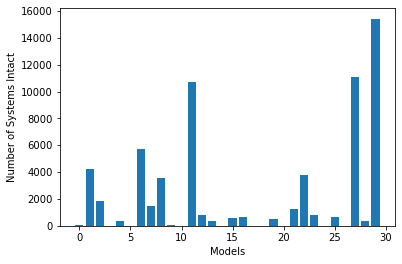

In [135]:
intacts = []
for i in range(len(file_names)): 
    #intact = dfs[i][dfs[i]['transit_status'].map(len) >= 5]
    intact = dfs[i][dfs[i].transit_status.str.len() >= 5]
    #intact = len(dfs[i].loc[len(dfs[i].transit_status) >= 5])
    #print(len(intact))
    intacts.append(len(intact))
    #print(logL)

# plot log likelihood per model
plt.bar(range(30), intacts)
plt.xlabel('Models')
plt.ylabel('Number of Systems Intact')
plt.show()

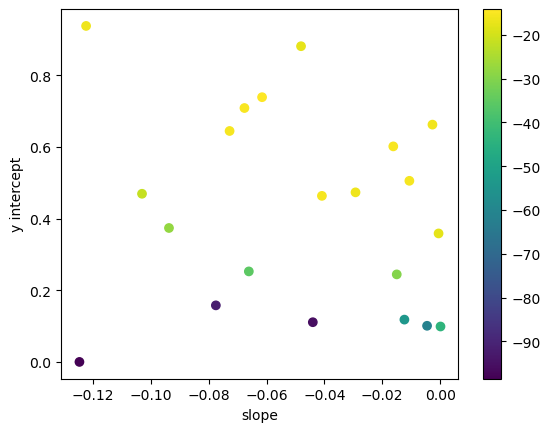

In [175]:
#plt.style.use('default')
logLs = []
ms = []
bs = []
#for i in range(len(file_names)): 
for i in range(20):
    lam = dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[i].loc[dfs[i].transit_multiplicity > 0]))
    logL = calculate_logL(k, lam)
    logLs.append(logL)
    ms.append(dfs[i]['slope'][0])
    bs.append(dfs[i]['y_intercept'][0])
#print(logLs, ms, bs)

lam_control = df_control.loc[df_control.transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(df_control.loc[df_control.transit_multiplicity > 0]))
logL_control = calculate_logL(k, lam_control)
#print(logL_control)
#print(bs)
#print(ms)

# plot log likelihood per model
plt.scatter(ms, bs, c=logLs)
plt.scatter(df_control.slope[0], df_control.y_intercept[0], c=logL_control, 
            cmap='viridis', vmin=min(logLs), vmax=max(logLs))
plt.xlabel('slope')
plt.ylabel('y intercept')
plt.colorbar()
plt.show()

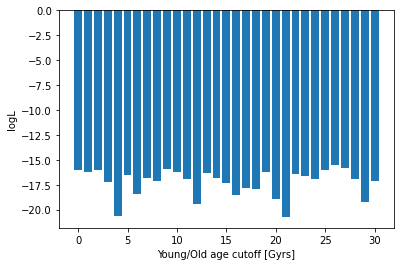

In [43]:
logLs = []
for i in range(len(file_names)): 
    lam = dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[i].loc[dfs[i].transit_multiplicity > 0]))
    #print(lam)
    logL = calculate_logL(k, lam)
    logLs.append(logL)
    #print(logL)

# plot log likelihood per model
plt.bar(range(31), logLs)
plt.xlabel('Young/Old age cutoff [Gyrs]')
plt.ylabel('logL')
plt.show()

In [49]:
np.argmax(logLs)

26

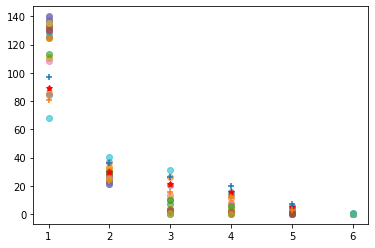

In [96]:
# plot each model's pre-normalized transit multiplicity distribution, and plot the data
tmult1 = []
tmult2 = []
tmult3 = []
tmodel3 = []
tmult4 = []
tmodel4 = []
tmult5 = []
tmodel5 = []
tmult6 = []
tmodel6 = []
for i in range(30):
    #print(dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts())
    current = dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts() * (161/len(dfs[i].loc[dfs[i].transit_multiplicity > 0]))
    tmult1.append(current[1])
    tmult2.append(current[2])
    try:
        tmult3.append(current[3])
        tmodel3.append(i)
    except:
        pass
    try:
        tmult4.append(current[4])
        tmodel4.append(i)
    except:
        pass
    try:
        tmult5.append(current[5])
        tmodel5.append(i)
    except:
        pass
    try:
        tmult6.append(current[6])
        tmodel6.append(i)
    except:
        pass
    plt.scatter(current.index, current, alpha=0.6)

plt.scatter(np.arange(6)[1:], k, marker=(5, 1), color='r')
plt.scatter(np.arange(7)[1:], k+np.sqrt(current), marker='+')
plt.scatter(np.arange(7)[1:], k-np.sqrt(current), marker='+')

# double check first model
#plt.scatter(dfs[0].loc[dfs[0].transit_multiplicity > 0].transit_multiplicity.value_counts().index, 
#            dfs[0].loc[dfs[0].transit_multiplicity > 0].transit_multiplicity.value_counts(), 
#            color='k', marker='+')
#plt.ylim([0, 800])
plt.show()

In [ ]:
dfs[i].loc[dfs[i].transit_multiplicity > 0].transit_multiplicity.value_counts()

### Troubleshooting

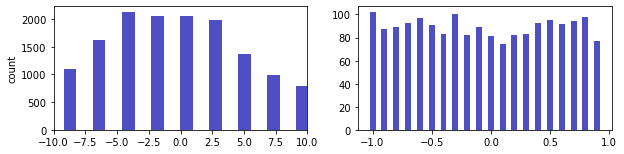

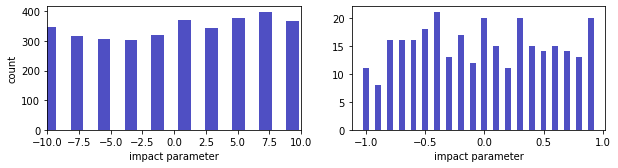

In [169]:
# how about for impact parameter?
# old
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.impact_parameters.explode(), bins=150)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlim([-10, 10])

ax = fig.add_subplot(2, 2, 2)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.impact_parameters.explode().loc[np.abs(transits_case2_old.impact_parameters.explode()) <= 1.], bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 0.05, color='#0504aa',alpha=0.7)

# young 
ax = fig.add_subplot(2, 2, 3)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.impact_parameters.explode(), bins=1000)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("impact parameter")
plt.xlim([-10, 10])

ax = fig.add_subplot(2, 2, 4)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.impact_parameters.explode().loc[np.abs(transits_case2_young.impact_parameters.explode()) <= 1.], bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 0.05, color='#0504aa',alpha=0.7)
plt.xlabel("impact parameter")

plt.show()

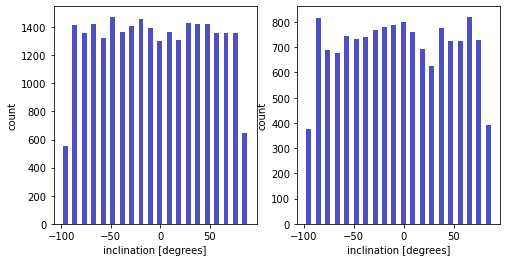

In [195]:
# how about for inclination?
# old
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.planet_inclinations_degrees.explode(), bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 5, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("inclination [degrees]")
#plt.xlim([-10, 10])

# young 
ax = fig.add_subplot(1, 2, 2)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.planet_inclinations_degrees.explode(), bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 5, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("inclination [degrees]")
#plt.xlim([-10, 10])

plt.show()

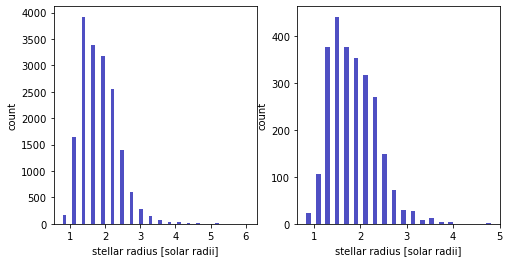

In [184]:
# I'm really running out of ideas now...what's left? R_star? a??
### stellar radius
# old
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.star_radius.explode(), bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 0.1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("stellar radius [solar radii]")
#plt.xlim([-10, 10])

# young 
ax = fig.add_subplot(1, 2, 2)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.star_radius.explode(), bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 0.1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("stellar radius [solar radii]")
#plt.xlim([-10, 10])

plt.show()

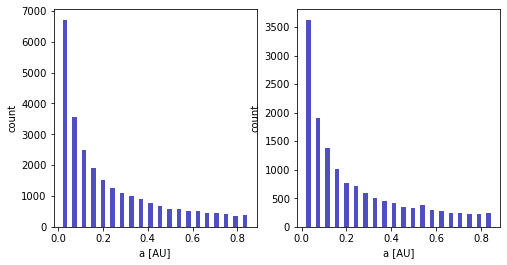

In [188]:
### semi-major axes
# old
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.semi_major_axes.explode(), bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 0.02, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("a [AU]")
#plt.xlim([-10, 10])

# young 
ax = fig.add_subplot(1, 2, 2)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.semi_major_axes.explode(), bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 0.02, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("a [AU]")
#plt.xlim([-10, 10])

plt.show()

In [142]:
"""
from math import lgamma

def uniform_lam(length, lam):
    return lam*np.ones(length)

def poisson_prob(k, lam):
    return np.power(lam, [Decimal(math.factorial(kth)) 
                                                     for kth in k]) * np.exp(lam) / ([Decimal(math.factorial(kth)) 
                                                     for kth in k])

# - log L = SUM from i to N (log k_i! - k_i log lamba_i + lambda_i)
def poisson_log_likelihood(length, k, lam):
    #term = [np.log(math.factorial(kth)) for kth in k]
    term1 = length * lam
    term2 = np.sum([lgamma(kth + 1) for kth in k])
    term3 = np.log(lam) * np.sum(k)
    return term3 - term1 - term2

num_samples = 20000 # in the case of lambda per set
# num_planets = length of period arrays, in the case of lambda per system
lam = 0.04*num_samples

# for each set, count and calculate expected number of systems with at least one transiting planet
norm_syst_array = []
syst_array = []
for i in range(len(file_names)):
    syst = len(dfs[i+1].loc[dfs[i+1].transit_multiplicity > 0])
    syst_array.append(syst)
    norm_syst_array.append(syst/num_samples)
print(syst_array)
print(norm_syst_array)

# okay, clearly I'm one level too high, since that gives me one logL. I need 10 logL's
for i in range(len(file_names)):
    lengths = []
    transits = []
    for j in range(len(dfs[1])):
        length = len(dfs[i+1].period_periods) # number of planets in system
        transit = dfs[i+1].transit_multiplicity # expected number of transiters
        

# calculate Poisson probability per set
print(poisson_log_likelihood(length=10, k=syst_array, lam=lam))
# calculate Poisson probability per system
print(poisson_log_likelihood(length=10, k=syst_array, lam=1.369))
"""

[791, 1023, 1295, 1353, 1353, 1395, 1393, 1406, 1381, 1351]
[0.03955, 0.05115, 0.06475, 0.06765, 0.06765, 0.06975, 0.06965, 0.0703, 0.06905, 0.06755]
-1395.0519409761619
-1395.0519409761619
